In [2]:
!pip install faiss-cpu


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.3/31.3 MB 72.9 MB/s eta 0:00:00


In [3]:

!pip install datasketch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.2/89.2 kB 4.8 MB/s eta 0:00:00


In [4]:
!pip install dataset

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.5/242.5 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 35.1 MB/s eta 0:00:00
  Attempting uninstall: sqlalchemy
    Found existing installation: SQLAlchemy 2.0.40
    Uninstalling SQLAlchemy-2.0.40:
      Successfully uninstalled SQLAlchemy-2.0.40
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ipython-sql 0.5.0 requires sqlalchemy>=2.0, but you have sqlalchemy 1.4.54 which is incompatible.


# preprocessing

In [7]:

from tqdm import tqdm
import pandas as pd
import numpy as np
import re
import os
import pickle
from sentence_transformers import SentenceTransformer, InputExample, losses, evaluation
from torch.utils.data import DataLoader
from datasketch import MinHash, MinHashLSH
import faiss
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# Load dataset
df = pd.read_csv("movies.csv")  # Adjust path if needed
df.fillna('', inplace=True)

# Clean text function
def clean_text(text):
    text = str(text).lower()
    text = re.sub(r'[^a-z0-9\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# 🔍 Fixing column names if needed
df.rename(columns={
    'Generes': 'Genres',
    'Plot Kyeword': 'Plot Keyword'
}, inplace=True)

# Apply cleaning to relevant columns
columns_to_clean = ['Genres', 'Top 5 Casts', 'Director', 'Plot Keyword', 'movie title']
for col in columns_to_clean:
    if col in df.columns:
        df[col] = df[col].apply(clean_text)

# ✅ Save cleaned full dataset
cleaned_full_file = "cleaned.csv"
df.to_csv(cleaned_full_file, index=False)
print(f"\n✅ Full cleaned dataset saved to: {cleaned_full_file}")

# --- Create metadata column ---
df['metadata'] = (
    df['Genres'] + ' ' +
    df['Top 5 Casts'] + ' ' +
    df['Director'] + ' ' +
    df['Plot Keyword']
)

# Rename for RAG pipeline
df.rename(columns={
    'movie title': 'title',
    'metadata': 'description'
}, inplace=True)

# Save metadata-only version
metadata_only = df[['title', 'description']]
metadata_file = "movies_metadata_cleaned.csv"
metadata_only.to_csv(metadata_file, index=False)
print(f"✅ Cleaned metadata saved to: {metadata_file}")

# Show a sample
print("\n📄 Sample cleaned metadata:")
print(metadata_only.head())

# Placeholder for next steps: pair generation, embedding, etc.
# train_pairs = []
# num_pos_pairs = 500
# num_neg_pairs = 500



✅ Full cleaned dataset saved to: cleaned.csv
✅ Cleaned metadata saved to: movies_metadata_cleaned.csv

📄 Sample cleaned metadata:
                     title                                        description
0         top gun maverick  action drama jack epps jr peter craig tom crui...
1  jurassic world dominion  action adventure scifi colin trevorrow derek c...
2                  top gun  action drama jack epps jr ehud yonay tom cruis...
3                lightyear  animation action adventure jason headley matth...
4               spiderhead  action crime drama rhett reese paul wernick ch...


# **creating pairs**

In [8]:
 #Create 1000 training pairs: (text1, text2, similarity score)
train_pairs = []

num_pos_pairs = 500
num_neg_pairs = 500

# Positive pairs: nearby movies are similar
for i in range(num_pos_pairs):
    idx1 = i
    idx2 = i + 1 if i + 1 < len(df) else i
    train_pairs.append(InputExample(texts=[df.loc[idx1, 'description'], df.loc[idx2, 'description']], label=1.0))

# Negative pairs: random distant movies
np.random.seed(42)
for _ in range(num_neg_pairs):
    idx1 = np.random.randint(0, len(df))
    idx2 = np.random.randint(0, len(df))
    if abs(idx1 - idx2) > 10:  # distant enough
        train_pairs.append(InputExample(texts=[df.loc[idx1, 'description'], df.loc[idx2, 'description']], label=0.0))

print(f"Total training pairs: {len(train_pairs)}")


Total training pairs: 1000


# ***models fine tuning***

In [9]:
import os
os.environ["WANDB_DISABLED"] = "true"

# Load pretrained models
models = {
    "MiniLM": SentenceTransformer('all-MiniLM-L6-v2'),
    "GTR": SentenceTransformer("sentence-transformers/gtr-t5-base"),
    "BERT": SentenceTransformer("all-mpnet-base-v2")
}

batch_size = 16
num_epochs = 1  # Increase if you want better tuning, beware of time

for model_name, model in models.items():
    print(f"\nFine-tuning {model_name}...")
    train_dataloader = DataLoader(train_pairs, shuffle=True, batch_size=batch_size)
    train_loss = losses.CosineSimilarityLoss(model)


    model.fit(train_objectives=[(train_dataloader, train_loss)],
              epochs=num_epochs,
              warmup_steps=10,
              show_progress_bar=True)

    # Save fine-tuned model locally
    model.save(f"{model_name}_fine_tuned")

print("Fine-tuning complete for all models.")


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

modules.json:   0%|          | 0.00/461 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/1.66k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.38k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/219M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.92k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/1.79k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`
Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


config.json:   0%|          | 0.00/115 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.36M [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/2.36M [00:00<?, ?B/s]

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.4k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/datasets/table.py:1395: FutureWarning: promote has been superseded by promote_options='default'.
  block_group = [InMemoryTable(cls._concat_blocks(list(block_group), axis=axis))]
/usr/local/lib/python3.11/dist-packages/datasets/table.py:1421: FutureWarning: promote has been superseded by promote_options='default'.
  table = cls._concat_blocks(blocks, axis=0)
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).



Fine-tuning MiniLM...


Computing widget examples:   0%|          | 0/1 [00:00<?, ?example/s]

Step,Training Loss


/usr/local/lib/python3.11/dist-packages/datasets/table.py:1395: FutureWarning: promote has been superseded by promote_options='default'.
  block_group = [InMemoryTable(cls._concat_blocks(list(block_group), axis=axis))]
/usr/local/lib/python3.11/dist-packages/datasets/table.py:1421: FutureWarning: promote has been superseded by promote_options='default'.
  table = cls._concat_blocks(blocks, axis=0)
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).



Fine-tuning GTR...


Computing widget examples:   0%|          | 0/1 [00:00<?, ?example/s]

Step,Training Loss


/usr/local/lib/python3.11/dist-packages/datasets/table.py:1395: FutureWarning: promote has been superseded by promote_options='default'.
  block_group = [InMemoryTable(cls._concat_blocks(list(block_group), axis=axis))]
/usr/local/lib/python3.11/dist-packages/datasets/table.py:1421: FutureWarning: promote has been superseded by promote_options='default'.
  table = cls._concat_blocks(blocks, axis=0)
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).



Fine-tuning BERT...


Computing widget examples:   0%|          | 0/1 [00:00<?, ?example/s]

Step,Training Loss


Fine-tuning complete for all models.


# **augmented metadata**

In [10]:
# Create neighbors index dictionary
movie_indices_dict = {
    i: list(range(max(0, i - 2), i)) + list(range(i + 1, min(len(df), i + 3)))
    for i in range(len(df))
}

def enrich_metadata(i):
    base = df.loc[i, "description"]  # <-- Changed from "metadata" to "description"
    neighbors = movie_indices_dict.get(i, [])
    neighbor_texts = " ".join([df.loc[n, "description"] for n in neighbors])  # <-- Changed here too
    return base + " " + neighbor_texts

# Enrich the metadata
df["metadata_augmented"] = [enrich_metadata(i) for i in tqdm(df.index, desc="Enriching Metadata")]

# Save augmented metadata CSV
df.to_csv("movies_augmented.csv", index=False)

print("Augmented metadata created and saved.")



Enriching Metadata: 100%|██████████| 24402/24402 [00:00<00:00, 29241.45it/s]


Augmented metadata created and saved.


In [11]:
from google.colab import files
files.download("cleaned.csv")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# **embeddings**

In [12]:
# Reload fine-tuned models
models_fine_tuned = {
    "MiniLM": SentenceTransformer("MiniLM_fine_tuned"),
    "GTR": SentenceTransformer("GTR_fine_tuned"),
    "BERT": SentenceTransformer("BERT_fine_tuned")
}
# Generate and save embeddings
for model_name, model in models_fine_tuned.items():
    print(f"Generating embeddings for {model_name} - original metadata...")
    # Changed "metadata" to "description" since you renamed it earlier
    emb_orig = model.encode(df["description"].tolist(), show_progress_bar=True)
    np.save(f"{model_name}_meta_finetuned.npy", emb_orig.astype(np.float32))

    print(f"Generating embeddings for {model_name} - augmented metadata...")
    emb_aug = model.encode(df["metadata_augmented"].tolist(), show_progress_bar=True)
    np.save(f"{model_name}_aug_finetuned.npy", emb_aug.astype(np.float32))

print("All embeddings generated and saved.")





Generating embeddings for MiniLM - original metadata...


Batches:   0%|          | 0/763 [00:00<?, ?it/s]

Generating embeddings for MiniLM - augmented metadata...


Batches:   0%|          | 0/763 [00:00<?, ?it/s]

Generating embeddings for GTR - original metadata...


Batches:   0%|          | 0/763 [00:00<?, ?it/s]

Generating embeddings for GTR - augmented metadata...


Batches:   0%|          | 0/763 [00:00<?, ?it/s]

Generating embeddings for BERT - original metadata...


Batches:   0%|          | 0/763 [00:00<?, ?it/s]

Generating embeddings for BERT - augmented metadata...


Batches:   0%|          | 0/763 [00:00<?, ?it/s]

All embeddings generated and saved.


# **min hashing**

In [13]:
from datasketch import MinHash

def get_minhash(text, num_perm=128):
    # Create MinHash object with num_perm permutations
    m = MinHash(num_perm=num_perm)
    # Tokenize the text (split by whitespace)
    tokens = text.split()
    for token in tokens:
        m.update(token.encode('utf8'))
    return m


# **lsh bucketing**

In [14]:
# Apply MinHash to 'description' instead of 'metadata'
df['minhash'] = df['description'].apply(get_minhash)

# Build LSH Buckets
lsh = MinHashLSH(threshold=0.2, num_perm=128)
for i, mh in tqdm(df['minhash'].items(), desc="Building LSH Buckets"):
    lsh.insert(f"movie_{i}", mh)

# Save LSH index
with open("lsh_index.pkl", "wb") as f:
    pickle.dump(lsh, f)

print("LSH buckets created and saved.")


Building LSH Buckets: 24402it [00:02, 9342.12it/s]


LSH buckets created and saved.


In [15]:
def recommend_from_embeddings(query_idx, embeddings, top_k=5):
    dim = embeddings.shape[1]
    index = faiss.IndexFlatL2(dim)
    index.add(embeddings)
    qvec = embeddings[query_idx].reshape(1, -1)
    D, I = index.search(qvec, top_k + 1)
    return I[0][1:], D[0][1:]

def plot_tsne(embeddings, title):
    tsne = TSNE(n_components=2, random_state=42)
    reduced = tsne.fit_transform(embeddings[:100])  # sample for speed
    plt.figure(figsize=(8,6))
    plt.scatter(reduced[:, 0], reduced[:, 1], alpha=0.7)
    plt.title(f"{title} Embeddings (TSNE)")
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.grid(True)
    plt.savefig(f"{title}_tsne.png")
    plt.show()


# **show columns**

In [16]:
print(df.columns)


Index(['title', 'Run Time', 'Rating', 'User Rating', 'Genres', 'Synopsis',
       'Plot Keyword', 'Director', 'Top 5 Casts', 'Writer', 'year', 'path',
       'description', 'metadata_augmented', 'minhash'],
      dtype='object')


# **movie input movie for recommendation**

Enter a movie title: spiderman
Found: spiderman

Top recommendations (using LSH + FAISS):
1. the amazing spiderman
2. spiderman 2
3. spiderman 3
4. atlantic rim resurrection
5. doctor strange in the multiverse of madness


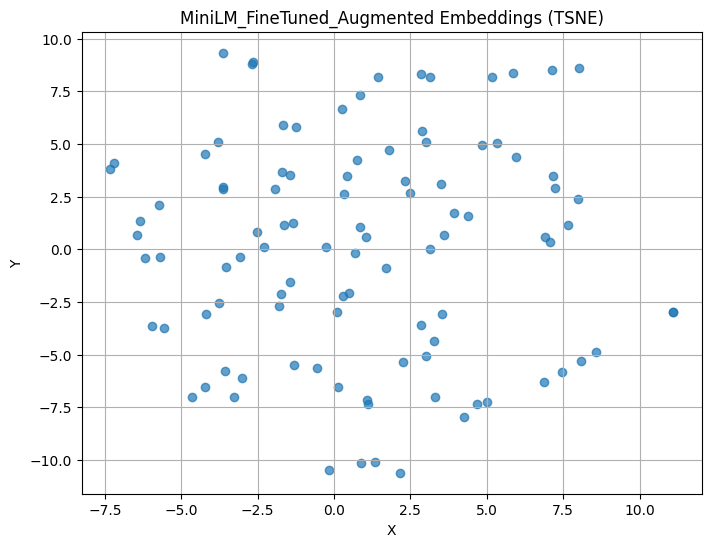


🎯 Model: MiniLM
👉 Original Metadata Recommendations:
['the amazing spiderman', 'spiderman 2', 'spiderman 3', 'spiderman far from home', 'secret headquarters']
✨ Augmented Metadata Recommendations:
['the accountant', 'skyfall', 'superman', 'starship troopers', 'xmen']

🎯 Model: GTR
👉 Original Metadata Recommendations:
['the amazing spiderman', 'spiderman 2', 'spiderman 3', 'spiderman far from home', 'secret headquarters']
✨ Augmented Metadata Recommendations:
['zack snyders justice league', 'operation fortune ruse de guerre', 'spiderman 2', 'the accountant', 'divergent']

🎯 Model: BERT
👉 Original Metadata Recommendations:
['the amazing spiderman', 'spiderman 2', 'spiderman 3', 'spiderman far from home', 'secret headquarters']
✨ Augmented Metadata Recommendations:
['batman v superman dawn of justice', 'the amazing spiderman', 'the amazing spiderman 2', 'the time machine', 'spiderman 3']


In [17]:
# Load embeddings
minilm_meta = np.load("MiniLM_meta_finetuned.npy")
minilm_aug = np.load("MiniLM_aug_finetuned.npy")
gtr_aug = np.load("GTR_aug_finetuned.npy")
bert_aug = np.load("BERT_aug_finetuned.npy")

title_to_idx = {t.lower(): i for i, t in enumerate(df['title'])}
movie_title = input("Enter a movie title: ").strip().lower()
query_idx = title_to_idx.get(movie_title)

if query_idx is None:
    print("Movie not found!")
else:
    print(f"Found: {df.loc[query_idx, 'title']}")

    # Candidate filtering with LSH
    keys = lsh.query(df.loc[query_idx, 'minhash'])
    candidate_idxs = [int(k.split("_")[1]) for k in keys if int(k.split("_")[1]) != query_idx]

    if candidate_idxs:
        sub_index = faiss.IndexFlatL2(minilm_meta.shape[1])
        sub_index.add(minilm_meta[candidate_idxs])
        D, I = sub_index.search(minilm_meta[query_idx].reshape(1, -1), k=min(5, len(candidate_idxs)))
        print("\nTop recommendations (using LSH + FAISS):")
        for rank, idx in enumerate(I[0]):
            print(f"{rank+1}. {df.loc[candidate_idxs[idx], 'title']}")
    else:
        print("No similar movies found 😕")

    # Plot t-SNE of fine-tuned augmented embeddings (MiniLM as example)
    plot_tsne(minilm_aug, "MiniLM_FineTuned_Augmented")

    # Show recommendations from original and augmented embeddings across all models
    for model_name, emb1, emb2 in [
        ("MiniLM", minilm_meta, minilm_aug),
        ("GTR", minilm_meta, gtr_aug),
        ("BERT", minilm_meta, bert_aug)
    ]:
        print(f"\n🎯 Model: {model_name}")
        print("👉 Original Metadata Recommendations:")
        orig_recs, _ = recommend_from_embeddings(query_idx, emb1)
        print([df.loc[i, "title"] for i in orig_recs])

        print("✨ Augmented Metadata Recommendations:")
        aug_recs, _ = recommend_from_embeddings(query_idx, emb2)
        print([df.loc[i, "title"] for i in aug_recs])




In [18]:
from sklearn.metrics import precision_score, recall_score, f1_score
import numpy as np
import matplotlib.pyplot as plt

def evaluate_model(embeddings, k=5):
    precisions = []
    recalls = []
    ndcgs = []
    maps = []

    for query_idx in range(50):  # Evaluate on first 50 movies
        true_neighbors = set(movie_indices_dict[query_idx])  # Ground truth: nearby movie indices
        recommended, _ = recommend_from_embeddings(query_idx, embeddings, top_k=k)
        recommended = set(recommended)

        relevant = len(true_neighbors & recommended)
        precision = relevant / k
        recall = relevant / len(true_neighbors) if true_neighbors else 0

        # Calculate NDCG
        relevance_scores = [1 if idx in true_neighbors else 0 for idx in recommended]
        dcg = sum([(2 ** rel - 1) / np.log2(i + 2) for i, rel in enumerate(relevance_scores)])
        idcg = sum([1 / np.log2(i + 2) for i in range(min(k, len(true_neighbors)))])
        ndcg = dcg / idcg if idcg > 0 else 0

        # Calculate MAP
        ap = 0
        hits = 0
        for i, item in enumerate(recommended):
            if item in true_neighbors:
                hits += 1
                ap += hits / (i + 1)
        map_score = ap / min(k, len(true_neighbors)) if true_neighbors else 0

        precisions.append(precision)
        recalls.append(recall)
        ndcgs.append(ndcg)
        maps.append(map_score)

    avg_precision = np.mean(precisions)
    avg_recall = np.mean(recalls)
    avg_ndcg = np.mean(ndcgs)
    avg_map = np.mean(maps)
    return avg_precision, avg_recall, avg_ndcg, avg_map

# Evaluate models
results = {}
for name, emb in [("MiniLM", minilm_aug), ("GTR", gtr_aug), ("BERT", bert_aug)]:
    prec, rec, ndcg, map_score = evaluate_model(emb)
    results[name] = {'precision': prec, 'recall': rec, 'ndcg': ndcg, 'map': map_score}


# **accuracies**

In [19]:
# Print accuracies
for model_name, metrics in results.items():
    print(f"{model_name}:")
    print(f"  Precision@5: {metrics['precision']:.4f}")
    print(f"  Recall@5: {metrics['recall']:.4f}")
    print(f"  NDCG@5: {metrics['ndcg']:.4f}")
    print(f"  MAP: {metrics['map']:.4f}")


MiniLM:
  Precision@5: 0.4840
  Recall@5: 0.6183
  NDCG@5: 0.6022
  MAP: 0.4938
GTR:
  Precision@5: 0.7080
  Recall@5: 0.9000
  NDCG@5: 0.8160
  MAP: 0.7443
BERT:
  Precision@5: 0.1440
  Recall@5: 0.1850
  NDCG@5: 0.1806
  MAP: 0.1171


## **bar charts**

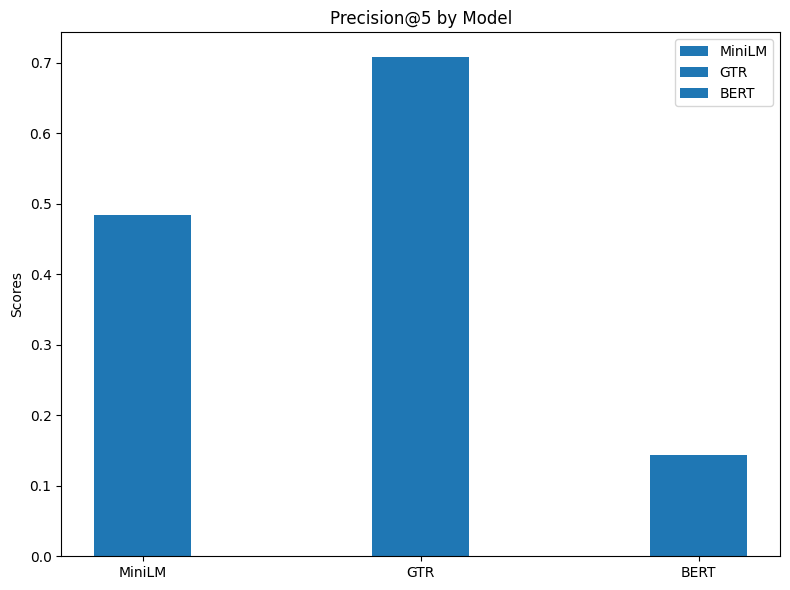

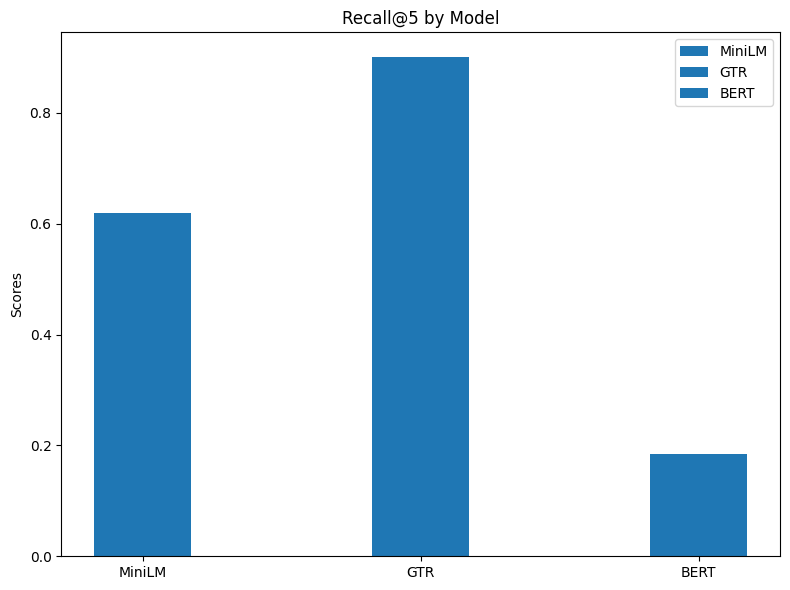

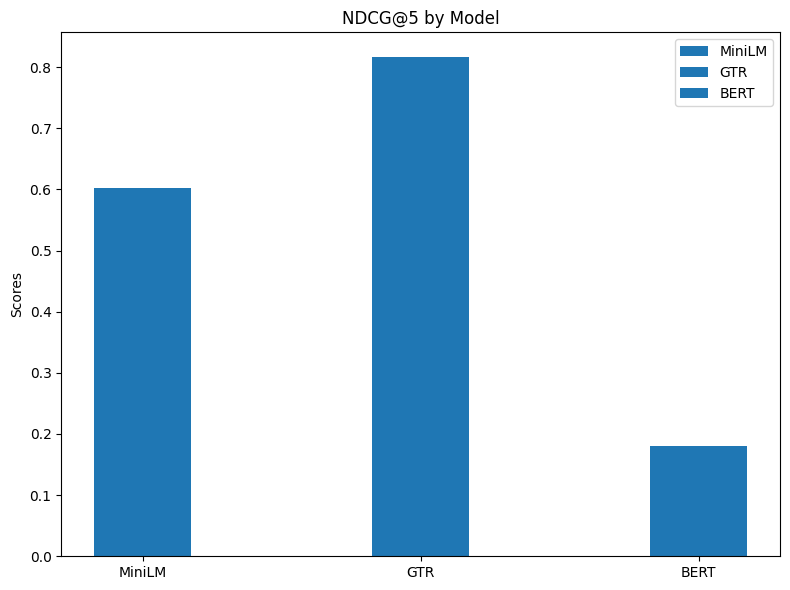

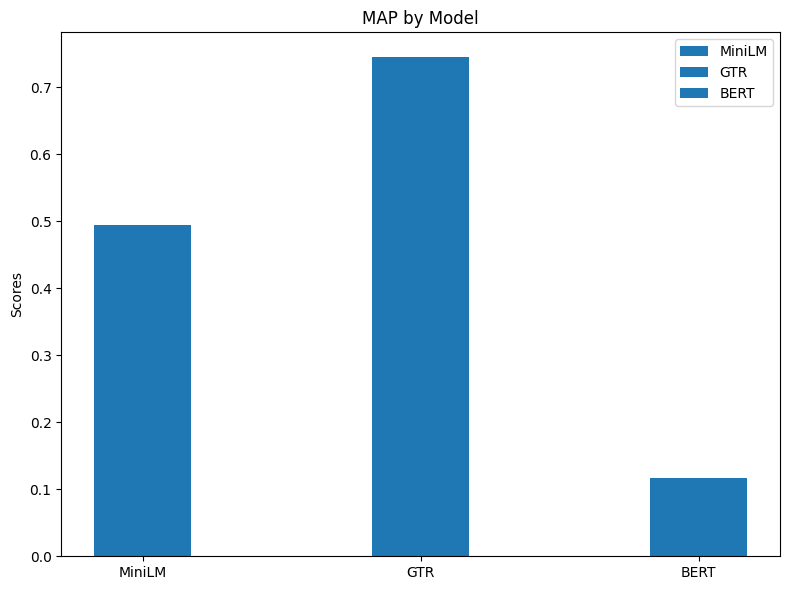

In [51]:
def generate_bar_chart(metrics, title):
    model_names = list(metrics.keys())
    values = [metrics[name] for name in model_names]

    x = np.arange(len(model_names))
    width = 0.35
    fig, ax = plt.subplots(figsize=(8, 6))

    ax.bar(x, values, width, label=model_names)

    ax.set_ylabel('Scores')
    ax.set_title(title)
    ax.set_xticks(x)
    ax.set_xticklabels(model_names)
    ax.legend()

    plt.tight_layout()
    plt.show()

# Generate bar charts for each metric
generate_bar_chart({name: results[name]['precision'] for name in results}, "Precision@5 by Model")
generate_bar_chart({name: results[name]['recall'] for name in results}, "Recall@5 by Model")
generate_bar_chart({name: results[name]['ndcg'] for name in results}, "NDCG@5 by Model")
generate_bar_chart({name: results[name]['map'] for name in results}, "MAP by Model")


In [21]:
!pip install sentence-transformers torch matplotlib


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 126.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 94.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 50.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 15.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 104.8 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitl

**# Training and Validation Loss Curves and accuracy curves**

Epoch 1/10 — Train Loss: 0.0969, Train Acc: 0.5325, Val Loss: 0.0510, Val Acc: 0.8650
Epoch 2/10 — Train Loss: 0.0432, Train Acc: 0.5238, Val Loss: 0.0337, Val Acc: 0.9250
Epoch 3/10 — Train Loss: 0.0329, Train Acc: 0.5325, Val Loss: 0.0345, Val Acc: 0.9050
Epoch 4/10 — Train Loss: 0.0267, Train Acc: 0.5437, Val Loss: 0.0302, Val Acc: 0.9000
Epoch 5/10 — Train Loss: 0.0189, Train Acc: 0.5513, Val Loss: 0.0244, Val Acc: 0.9650
Epoch 6/10 — Train Loss: 0.0170, Train Acc: 0.5437, Val Loss: 0.0180, Val Acc: 0.9450
Epoch 7/10 — Train Loss: 0.0124, Train Acc: 0.5437, Val Loss: 0.0179, Val Acc: 0.9550
Epoch 8/10 — Train Loss: 0.0163, Train Acc: 0.5600, Val Loss: 0.0255, Val Acc: 0.9200
Epoch 9/10 — Train Loss: 0.0094, Train Acc: 0.5663, Val Loss: 0.0166, Val Acc: 0.9400
Epoch 10/10 — Train Loss: 0.0094, Train Acc: 0.5837, Val Loss: 0.0345, Val Acc: 0.9050

Threshold tuning on validation set:
Threshold: 0.1 — Accuracy: 0.6750
Threshold: 0.2 — Accuracy: 0.7550
Threshold: 0.3 — Accuracy: 0.8300


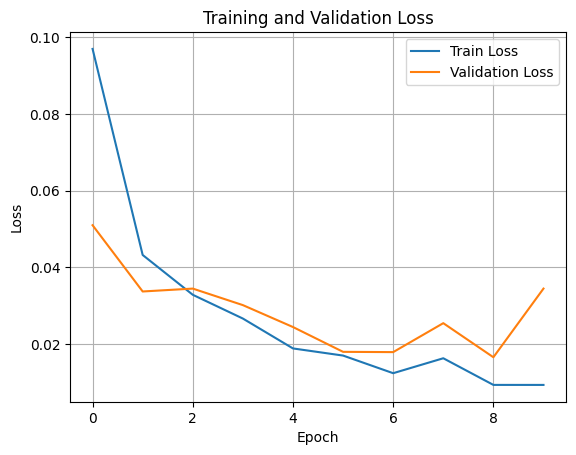

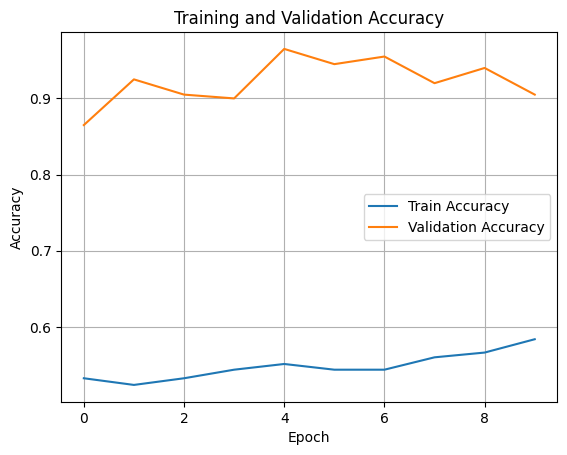

In [50]:
from torch.utils.data import Dataset, DataLoader, random_split
import torch
import torch.nn.functional as F
from sentence_transformers import SentenceTransformer, InputExample
import matplotlib.pyplot as plt

model = SentenceTransformer("all-mpnet-base-v2")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
SIMILARITY_THRESHOLD = 0.3

# Custom dataset
class MovieDataset(Dataset):
    def __init__(self, pairs):
        self.pairs = pairs

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        example = self.pairs[idx]
        return example.texts[0], example.texts[1], float(example.label)

# Sentence encoding
def encode_texts(texts):
    tokens = model.tokenize(texts)
    for key in tokens:
        tokens[key] = tokens[key].to(device)
    return model.forward(tokens)['sentence_embedding']

dataset = MovieDataset(train_pairs)
train_set, val_set = random_split(dataset, [int(0.8 * len(dataset)), len(dataset) - int(0.8 * len(dataset))])
train_loader = DataLoader(train_set, batch_size=16, shuffle=True)
val_loader = DataLoader(val_set, batch_size=16)

# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=2e-5)

# Tracking
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

epochs = 10

for epoch in range(epochs):
    model.train()
    total_loss, correct, total = 0, 0, 0

    for text1, text2, labels in train_loader:
        embeddings1 = encode_texts(text1)
        embeddings2 = encode_texts(text2)

        labels = labels.clone().detach().float().to(device)
        labels = labels * 2 - 1

        optimizer.zero_grad()
        loss = F.cosine_embedding_loss(embeddings1, embeddings2, labels, margin=0.5)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        sims = F.cosine_similarity(embeddings1, embeddings2)
        preds = torch.where(sims > 0.0, torch.tensor(1.0, device=device), torch.tensor(-1.0, device=device))
        correct += (preds == labels).sum().item()
        total += len(labels)

    train_losses.append(total_loss / len(train_loader))
    train_accuracies.append(correct / total)

    # Validation
    model.eval()
    val_loss, val_correct, val_total = 0, 0, 0

    with torch.no_grad():
        for text1, text2, labels in val_loader:
            embeddings1 = encode_texts(text1)
            embeddings2 = encode_texts(text2)

            labels = labels.clone().detach().float().to(device)
            labels = labels * 2 - 1  # Convert to -1/+1

            loss = F.cosine_embedding_loss(embeddings1, embeddings2, labels, margin=0.5)
            val_loss += loss.item()


            sims = F.cosine_similarity(embeddings1, embeddings2)

            threshold = 0.5
            preds = torch.where(sims > threshold, torch.tensor(1.0, device=device), torch.tensor(-1.0, device=device))

            val_correct += (preds == labels).sum().item()
            val_total += len(labels)

    val_losses.append(val_loss / len(val_loader))
    val_accuracies.append(val_correct / val_total)

    print(f"Epoch {epoch+1}/{epochs} — Train Loss: {train_losses[-1]:.4f}, Train Acc: {train_accuracies[-1]:.4f}, "
          f"Val Loss: {val_losses[-1]:.4f}, Val Acc: {val_accuracies[-1]:.4f}")


print("\nThreshold tuning on validation set:")
model.eval()
with torch.no_grad():
    all_preds = []
    all_labels = []
    for text1, text2, labels in val_loader:
        emb1 = encode_texts(text1)
        emb2 = encode_texts(text2)
        sims = F.cosine_similarity(emb1, emb2).cpu()
        labels = labels.clone().detach().float()
        labels = labels * 2 - 1  # Convert to -1/+1
        all_preds.extend(sims.tolist())
        all_labels.extend(labels.tolist())

    for thresh in [0.1, 0.2, 0.3, 0.4, 0.5]:
        preds = [1.0 if s > thresh else -1.0 for s in all_preds]
        acc = sum([1 for p, l in zip(preds, all_labels) if p == l]) / len(all_labels)
        print(f"Threshold: {thresh:.1f} — Accuracy: {acc:.4f}")

# Plot Loss
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plot Accuracy
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()


# **PR Curve for Movie Recommendations**

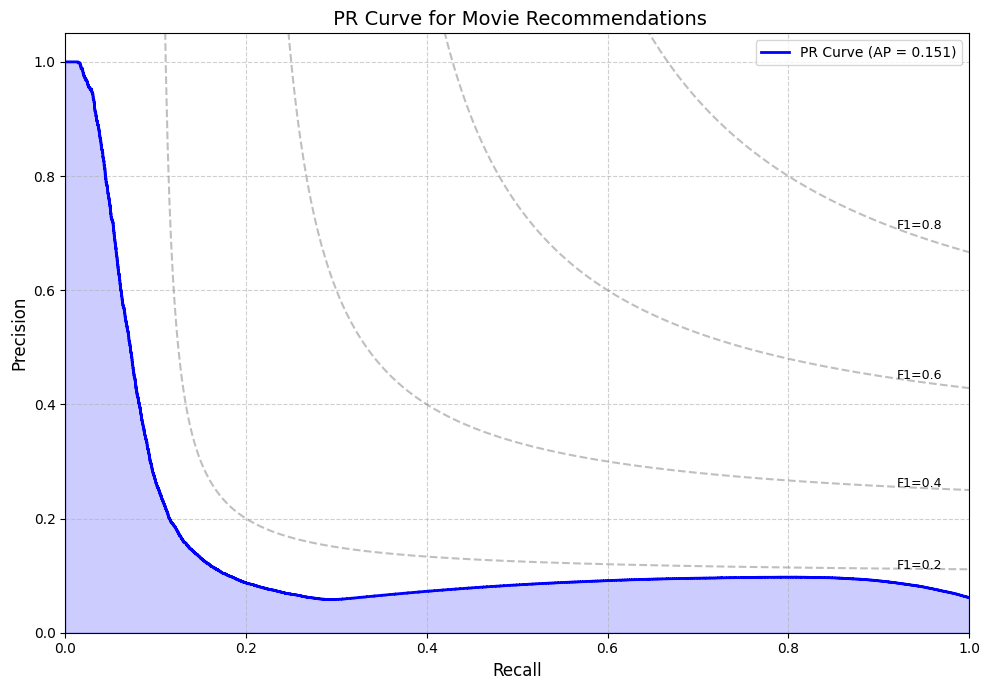

In [61]:
def compute_pr_curve(embeddings, movie_indices_dict, top_k=None, batch_size=100):
    """
    Computes precision-recall inputs by comparing each movie's embedding to others using batching.

    Parameters:
    - embeddings: np.array of shape (num_movies, dim)
    - movie_indices_dict: dict with {movie_idx: set of relevant indices}
    - top_k: limit to top_k retrieved results per query
    - batch_size: number of queries to process per batch

    Returns:
    - y_true: binary labels
    - y_scores: similarity scores
    """
    num_movies = embeddings.shape[0]
    all_scores = []
    all_labels = []

    norm_emb = embeddings / np.linalg.norm(embeddings, axis=1, keepdims=True)

    for start_idx in range(0, num_movies, batch_size):
        end_idx = min(start_idx + batch_size, num_movies)
        batch_queries = norm_emb[start_idx:end_idx]  # shape: (B, D)
        sims = np.dot(norm_emb, batch_queries.T)     # shape: (num_movies, B)

        for i, query_idx in enumerate(range(start_idx, end_idx)):
            sim_scores = sims[:, i]
            sim_scores[query_idx] = -np.inf

            true_neighbors = set(movie_indices_dict.get(query_idx, []))
            labels = np.array([1 if j in true_neighbors else 0 for j in range(num_movies)])

            if top_k is not None:
                top_indices = np.argpartition(sim_scores, -top_k)[-top_k:]
                scores = sim_scores[top_indices]
                labels = labels[top_indices]
            else:
                scores = sim_scores
                labels = labels

            all_scores.extend(scores.tolist())
            all_labels.extend(labels.tolist())

    return np.array(all_labels), np.array(all_scores)
y_true, y_scores = compute_pr_curve(embedding_to_eval, movie_indices_dict, top_k=50)
plot_precision_recall(y_true, y_scores, title=" PR Curve for Movie Recommendations")


# **ROC Curve for Movie Recommendations**

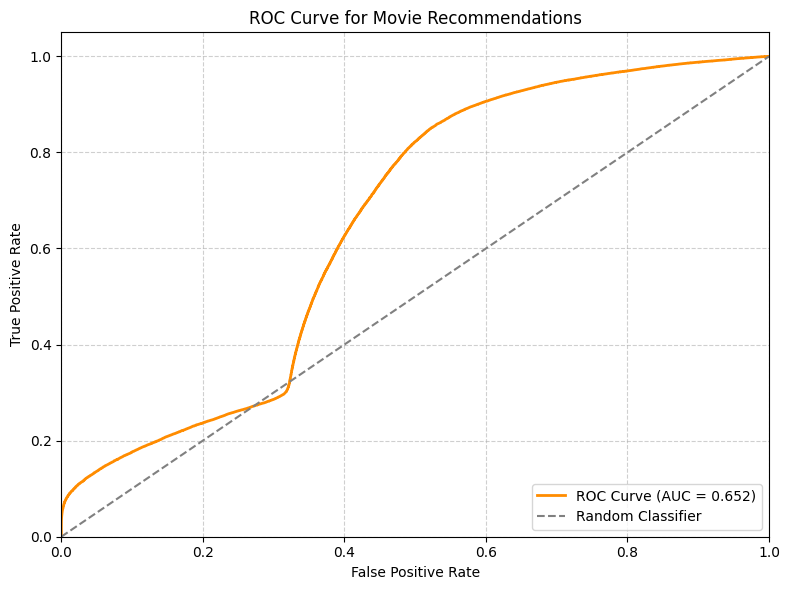

In [62]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

def plot_roc_curve(y_true, y_scores, title="ROC Curve for Movie Recommendations"):
    """
    Plot ROC curve with AUC.
    """
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    auc_score = roc_auc_score(y_true, y_scores)

    # Plotting
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc_score:.3f})', color='darkorange', linewidth=2)
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random Classifier')

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc='lower right')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.tight_layout()
    plt.show()


y_true, y_scores = compute_pr_curve(embedding_to_eval, movie_indices_dict, top_k=50)
plot_roc_curve(y_true, y_scores, title="ROC Curve for Movie Recommendations")


# **NDCG@K Curve**

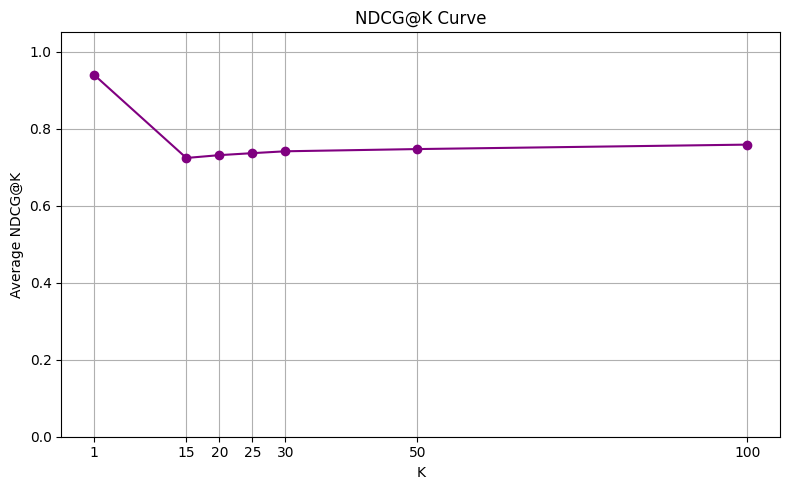

In [82]:
def compute_ndcg_curve(embeddings, movie_indices_dict, k_values=[1, 15, 20, 25, 30, 50, 100]):
    ndcg_scores = []

    for k in k_values:
        ndcgs = []
        for query_idx in range(50):  # Evaluate on first 50 movies
            true_neighbors = set(movie_indices_dict.get(query_idx, []))
            recommended, _ = recommend_from_embeddings(query_idx, embeddings, top_k=k)
            relevance = [1 if idx in true_neighbors else 0 for idx in recommended]

            dcg = sum([(2 ** rel - 1) / np.log2(i + 2) for i, rel in enumerate(relevance)])
            idcg = sum([1 / np.log2(i + 2) for i in range(min(k, len(true_neighbors)))])
            ndcg = dcg / idcg if idcg > 0 else 0
            ndcgs.append(ndcg)

        ndcg_scores.append(np.mean(ndcgs))

    return k_values, ndcg_scores

# Compute and plot
k_vals, ndcg_vals = compute_ndcg_curve(minilm_aug, movie_indices_dict)

plt.figure(figsize=(8, 5))
plt.plot(k_vals, ndcg_vals, marker='o', color='purple')
plt.title("NDCG@K Curve")
plt.xlabel("K")
plt.ylabel("Average NDCG@K")
plt.grid(True)
plt.xticks(k_vals)
plt.ylim(0, 1.05)
plt.tight_layout()
plt.show()


# **Movie-Movie Similarity (LSH Buckets) for First 50 Movies**

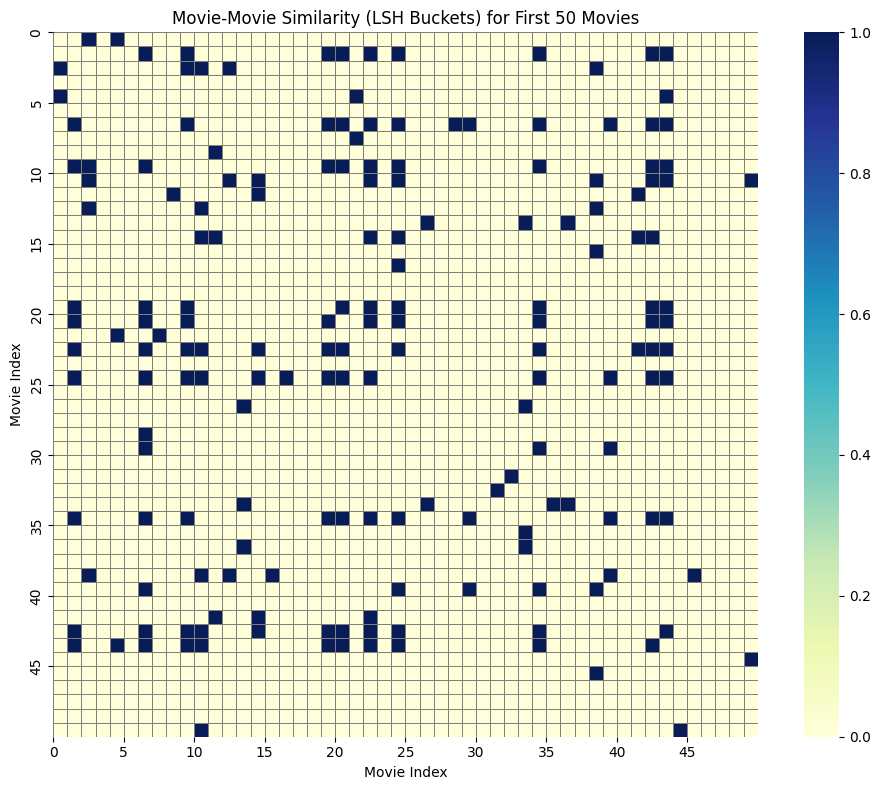

In [87]:
import seaborn as sns


item_item_matrix = np.zeros((50, 50))
for i in range(50):
    keys = lsh.query(df.loc[i, 'minhash'])
    neighbors = [int(k.split("_")[1]) for k in keys if int(k.split("_")[1]) != i and int(k.split("_")[1]) < 50]
    for n in neighbors:
        item_item_matrix[i, n] = 1

plt.figure(figsize=(10, 8))
sns.heatmap(item_item_matrix, cmap='YlGnBu', linewidths=0.5, linecolor='gray', cbar=True, square=True)
plt.title("Movie-Movie Similarity (LSH Buckets) for First 50 Movies")
plt.xlabel("Movie Index")
plt.ylabel("Movie Index")
plt.xticks(ticks=np.arange(0, 50, 5), labels=np.arange(0, 50, 5))
plt.yticks(ticks=np.arange(0, 50, 5), labels=np.arange(0, 50, 5))
plt.tight_layout()
plt.show()


# **Training Time per Epoch**

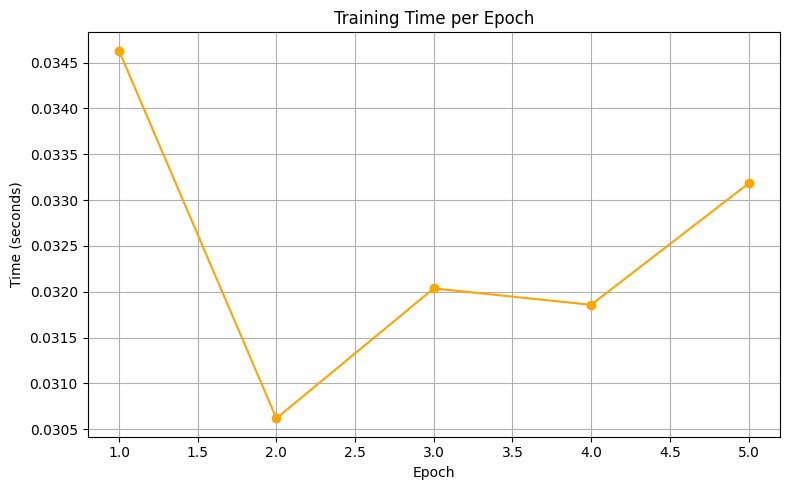

In [88]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import time
import matplotlib.pyplot as plt

X = torch.randn(1000, 20)
y = torch.randint(0, 2, (1000,))

dataset = TensorDataset(X, y)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

class SimpleModel(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(SimpleModel, self).__init__()
        self.fc = nn.Linear(input_dim, output_dim)

    def forward(self, x):
        return self.fc(x)

model = SimpleModel(input_dim=20, output_dim=2)


loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 5


epoch_times = []
for epoch in range(num_epochs):
    start_time = time.time()
    model.train()
    for batch in dataloader:
        inputs, targets = batch
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_fn(outputs, targets)
        loss.backward()
        optimizer.step()
    end_time = time.time()
    epoch_times.append(end_time - start_time)

plt.figure(figsize=(8, 5))
plt.plot(range(1, num_epochs + 1), epoch_times, marker='o', color='orange')
plt.title("Training Time per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Time (seconds)")
plt.grid(True)
plt.tight_layout()
plt.show()


# **Top Recommendation Evaluation**

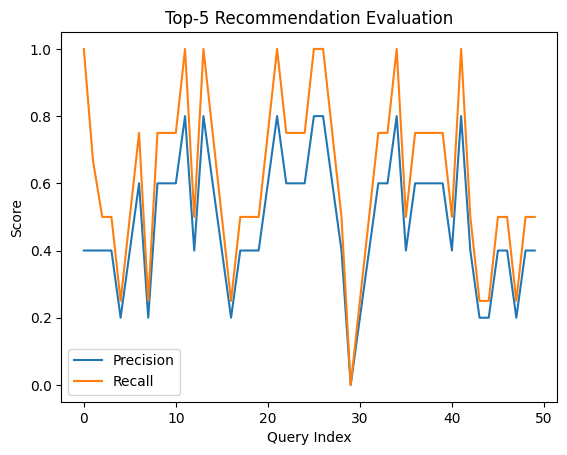

In [89]:
def plot_top_n_evaluation(embeddings, k=5):
    precisions = []
    recalls = []

    for query_idx in range(50):  # Using the first 50 movies for simplicity
        true_neighbors = set(movie_indices_dict[query_idx])
        recommended, _ = recommend_from_embeddings(query_idx, embeddings, top_k=k)

        relevant = [1 if idx in true_neighbors else 0 for idx in recommended]
        precision = sum(relevant) / k
        recall = sum(relevant) / len(true_neighbors) if true_neighbors else 0

        precisions.append(precision)
        recalls.append(recall)

    plt.plot(precisions, label="Precision")
    plt.plot(recalls, label="Recall")
    plt.xlabel('Query Index')
    plt.ylabel('Score')
    plt.title(f'Top-{k} Recommendation Evaluation')
    plt.legend()
    plt.show()


plot_top_n_evaluation(minilm_aug)
